Epoch [1/5] Train Acc: 89.96%
Epoch [2/5] Train Acc: 96.08%
Epoch [3/5] Train Acc: 96.98%
Epoch [4/5] Train Acc: 97.53%
Epoch [5/5] Train Acc: 97.92%
Test Accuracy: 98.53%


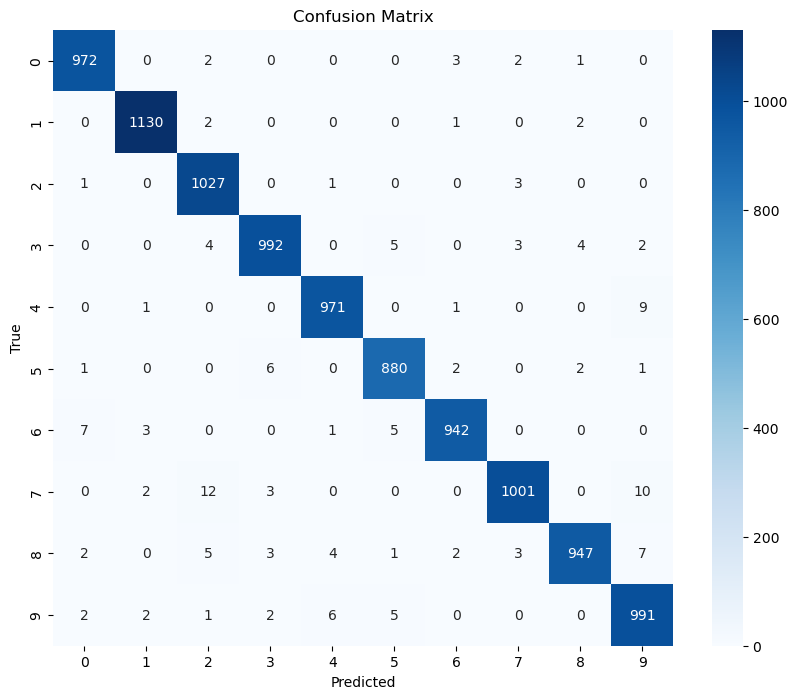


所有结果已保存至 results/ 目录


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

# 超参数设置
BATCH_SIZE = 64
EPOCHS = 5
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 创建保存结果的目录
os.makedirs('results', exist_ok=True)

# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 加载数据集
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# 定义CNN模型
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, 3)  # 1输入通道→1输出通道
        self.conv2 = nn.Conv2d(1, 64, 3)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 64 * 5 * 5)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


model = CNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# 训练和测试记录
train_acc_history = []
test_acc_history = []
all_preds = []
all_labels = []


def train():
    model.train()
    for epoch in range(EPOCHS):
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_acc = 100 * correct / total
        train_acc_history.append(epoch_acc)
        print(f"Epoch [{epoch + 1}/{EPOCHS}] Train Acc: {epoch_acc:.2f}%")


def test():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100 * correct / total
    test_acc_history.append(test_acc)
    print(f"Test Accuracy: {test_acc:.2f}%")


# 执行训练和测试
train()
test()


# 生成混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('./results/confusion_matrix.png')
plt.show()
plt.close()

# 保存前200个测试样本
test_images, test_labels = next(iter(DataLoader(test_dataset, batch_size=200, shuffle=False)))

test_images = test_images * 0.3081 + 0.1307  # 逆归一化
test_images = test_images * 255.0  # 还原到 [0, 255]
test_images = test_images.clamp(0, 255).byte()  # 转换为 uint8 并截断范围

flatten_images = test_images.view(-1, 28 * 28).cpu().numpy()
df = pd.DataFrame(flatten_images)
df['True_Label'] = test_labels.numpy()
df['Predicted'] = np.array(all_preds[:200])

# df.to_csv('./results/test_samples.csv', index=False)

print("\n所有结果已保存至 results/ 目录")

# torch.save(model.state_dict(), './results/mnist_cnn.pth')


第一层卷积核权值：
[[ 0.38094833  0.36529493  0.24226627]
 [ 0.44256777  0.33907723  0.21108471]
 [ 0.2424691   0.09382253 -0.10800746]]


C:\Users\ytche\AppData\Local\Temp\ipykernel_22520\3018383950.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./results/mnist_cnn.pth')

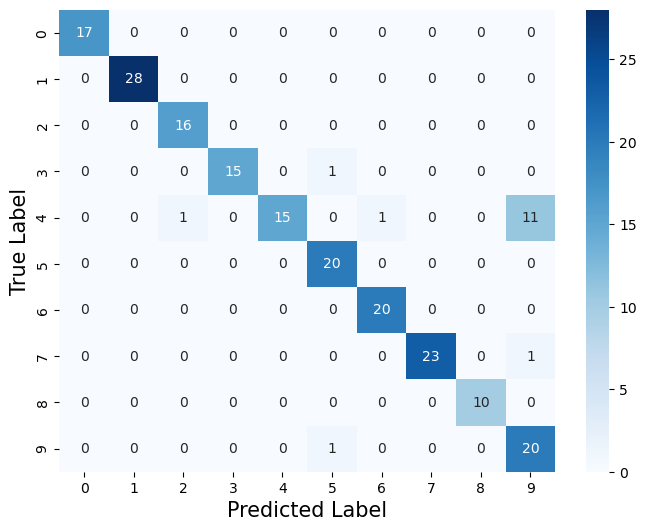

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# 设备选择
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 加载测试数据集（200 张）
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False)
test_images, test_labels = next(iter(test_loader))
test_images, test_labels = test_images.to(DEVICE), test_labels.to(DEVICE)

# 定义 CNN 结构（需与训练时相同）
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, 3)
        self.conv2 = nn.Conv2d(1, 64, 3)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 64 * 5 * 5)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# 加载训练好的模型
model = CNN().to(DEVICE)
model.load_state_dict(torch.load('./results/mnist_cnn.pth'))
model.eval()

# 打印第一层卷积核权重
conv1_weights = model.conv1.weight.data.cpu().numpy()
print("第一层卷积核权值：")
print(conv1_weights.squeeze())

csv_data = pd.read_csv('./o_conv.csv', header=None).values
if csv_data.shape != (200, 676):
    raise ValueError("CSV 数据维度错误，应为 (200, 676)")

# 转换为 PyTorch Tensor，调整形状为 (200, 26, 26)（
new_output = torch.tensor(csv_data, dtype=torch.float32, device=DEVICE).view(200, 1, 26, 26)

# 定义钩子函数，从 CSV 读取数据作为 conv1 输出
def hook_function(module, input, output):   
    return new_output  # 直接返回替换后的输出

# 注册钩子到第一层卷积
hook = model.conv1.register_forward_hook(hook_function)

# 推理（使用 CSV 替换 conv1 输出）
with torch.no_grad():
    outputs = model(test_images)
    _, predicted = torch.max(outputs, 1)

# 计算混淆矩阵
conf_matrix = confusion_matrix(test_labels.cpu().numpy(), predicted.cpu().numpy())

# 绘制并保存混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label",fontsize=15)
plt.ylabel("True Label",fontsize=15)
plt.savefig("./results/confusion_matrix_non.png")
plt.show()

# 保存混淆矩阵到 CSV
conf_matrix_df = pd.DataFrame(conf_matrix, index=range(10), columns=range(10))
conf_matrix_df.to_csv("./results/confusion_matrix_quant.csv", index=False)

# 取消钩子
hook.remove()
